# Compare converted OSMnx network versus reference network

## Script usage

Step 1 - Define variables for execution   
There are few parameters for this script:   
site_area: the polygon shapefile (or type supported by fiona, may require modification) for retrieving OSM data      
node_ref: a shapefile containing nodes of the reference network
edge_ref: a shapefile containing edges of the reference network
ref_proj: the projection of reference network.   
rounding: round the 'rounding' decimal when dealing with imprecision of floating point number

   
Step 2 - Execute the block step by step   

## Metric used   
Average Degree Connectivity   
Clustering Coefficient   
Average Path Length   
Efficiency   
Flow Hierarchy   
Betweenness Centrality   
Closeness Centrality   
Degree Centrality   

In [1]:
import os

# Define variables for the execution

if not 'wd' in globals():
    wd = os.getcwd()

site_area = os.path.join(wd, "OSM", "osmnx", "site_area_4326.shp")
node_ref = os.path.join(wd, "iB1000", "4326", "Ped_Junc_4326.shp")
edge_ref = os.path.join(wd, "iB1000", "4326", "Ped_Line_4326.shp")
ref_proj = 'EPSG:4326'

In [2]:
# Try to import related package
# If uninstalled, then try to install it
try:
    import sys
    import pip
    import time
    import math
    
    import fiona
    import geopandas as gpd
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import networkx as nx
    import numpy as np
    from osgeo import ogr
    import osmnx as ox
    import scipy as sc
    import shapely
    from shapely.geometry import LineString
    from shapely.geometry import Point
    from shapely.geometry import Polygon
    from statsmodels.distributions.empirical_distribution import ECDF
    from itertools import chain
    from collections import Counter
except ImportError:
    print("Required package not found.")


In [3]:
# Read data using OSMNX
c = fiona.open(site_area)
pol = c.next()
geom = shapely.geometry.shape(pol['geometry'])
graph_osmnx = ox.graph_from_polygon(geom, network_type='walk')

D:\FYP\conda\lib\site-packages\ipykernel_launcher.py:3: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
# Now extend the NetworkX class and NetworkX function.
# NetworkX is licensed through BSD 3-Clause (Revised) License.
# For license information, please refer to the License Information in the LICENSE_NetworkX.md in License folder.
class MyDiGraph(nx.DiGraph):
    pass
    def add_edge_without_add_node(self, u_for_edge, v_for_edge, key=None, **attr):
        """Add an edge between u and v.
        The nodes u and v will be automatically added if they are
        not already in the graph.
        Edge attributes can be specified with keywords or by directly
        accessing the edge's attribute dictionary. See examples below.
        Parameters
        ----------
        u, v : nodes
            Nodes can be, for example, strings or numbers.
            Nodes must be hashable (and not None) Python objects.
        attr : keyword arguments, optional
            Edge data (or labels or objects) can be assigned using
            keyword arguments.
        See Also
        --------
        add_edges_from : add a collection of edges
        Notes
        -----
        Adding an edge that already exists updates the edge data.
        Many NetworkX algorithms designed for weighted graphs use
        an edge attribute (by default `weight`) to hold a numerical value.
        Examples
        --------
        The following all add the edge e=(1, 2) to graph G:
        >>> G = nx.Graph()   # or DiGraph, MultiGraph, MultiDiGraph, etc
        >>> e = (1, 2)
        >>> G.add_edge(1, 2)           # explicit two-node form
        >>> G.add_edge(*e)             # single edge as tuple of two nodes
        >>> G.add_edges_from( [(1, 2)] ) # add edges from iterable container
        Associate data to edges using keywords:
        >>> G.add_edge(1, 2, weight=3)
        >>> G.add_edge(1, 3, weight=7, capacity=15, length=342.7)
        For non-string attribute keys, use subscript notation.
        >>> G.add_edge(1, 2)
        >>> G[1][2].update({0: 5})
        >>> G.edges[1, 2].update({0: 5})
        """
        u, v = u_for_edge, v_for_edge
        # add nodes
        # Check if u may exist
        u_exists = False
        v_exists = False
        if u not in self._succ:
            self._succ[u] = self.adjlist_inner_dict_factory()
            self._pred[u] = self.adjlist_inner_dict_factory()
            ### WARNING: EDITED
            attribute = dict()
            attribute['x'] = u[0]
            attribute['y'] = u[1]
            self._node[u] = self.node_attr_dict_factory(**attribute)
            ### EDITED REGION END
        if v not in self._succ:
            self._succ[v] = self.adjlist_inner_dict_factory()
            self._pred[v] = self.adjlist_inner_dict_factory()
            ### WRANING: EDITED
            attribute = dict()
            attribute['x'] = v[0]
            attribute['y'] = v[1]
            self._node[v] = self.node_attr_dict_factory(**attribute)
            ### EDITED REGION END
        # add the edge
        datadict = self._adj[u].get(v, self.edge_attr_dict_factory())
        datadict.update(attr)
        self._succ[u][v] = datadict
        
    

def read_shp_with_node(paths, simplify=False):
    """Generates a networkx.DiGraph from shapefiles. Point geometries are
    translated into nodes, lines into edges. Coordinate tuples are used as
    keys. Attributes are preserved, line geometries are simplified into start
    and end coordinates. Accepts a single shapefile or directory of many
    shapefiles.

    "The Esri Shapefile or simply a shapefile is a popular geospatial vector
    data format for geographic information systems software [1]_."

    Parameters
    ----------
    paths : list
       a list of two shapefiles.
       paths[0] should be the node shapefile of reference network.
       paths[1] shall be the shapefile of edges.

    simplify:  bool
        If ``True``, simplify line geometries to start and end coordinates.
        If ``False``, and line feature geometry has multiple segments, the 
        non-geometric attributes for that feature will be repeated for each 
        edge comprising that feature.

    Returns
    -------
    G : MyDiGraph extended from DiGraph graph

    Examples
    --------
    >>> G=nx.read_shp_with_node('node.shp', 'edge.shp') # doctest: +SKIP

    References
    ----------
    .. [1] http://en.wikipedia.org/wiki/Shapefile
    """
    try:
        from osgeo import ogr
    except ImportError:
        raise ImportError("read_shp requires OGR: http://www.gdal.org/")

    if not isinstance(paths, list):
        return

    
    ### WARNING: EDITED
    net = MyDiGraph()
    ### Edit region end
    
    ### WARNING EDITED:
    for path in paths:
        ### Edited region end
        shp = ogr.Open(path)
        for lyr in shp:
            fields = [x.GetName() for x in lyr.schema]
            for f in lyr:
                flddata = [f.GetField(f.GetFieldIndex(x)) for x in fields]
                g = f.geometry()
                attributes = dict(zip(fields, flddata))
                attributes["ShpName"] = lyr.GetName()
                if g.GetGeometryType() == 1:  # point
                    point = g.GetPoint_2D(0)
                    attributes['x'] = point[0]
                    attributes['y'] = point[1]
                    net.add_node(point, **attributes)
                if g.GetGeometryType() == 2:  # linestring
                    last = g.GetPointCount() - 1
                    attributes['length'] = g.Length()
                    if simplify:
                        attributes["Wkb"] = g.ExportToWkb()
                        attributes["Wkt"] = g.ExportToWkt()
                        attributes["Json"] = g.ExportToJson()
                        net.add_edge(g.GetPoint_2D(0), g.GetPoint_2D(last), **attributes)
                    else:
                        # separate out each segment as individual edge
                        for i in range(last):
                            # Rounded to 3 decimal
                            pt1 = g.GetPoint_2D(i)
                            pt2 = g.GetPoint_2D(i+1)
                            segment = ogr.Geometry(ogr.wkbLineString)
                            segment.AddPoint_2D(pt1[0], pt1[1])
                            segment.AddPoint_2D(pt2[0], pt2[1])
                            attributes["Wkb"] = segment.ExportToWkb()
                            attributes["Wkt"] = segment.ExportToWkt()
                            attributes["Json"] = segment.ExportToJson()
        
                            net.add_edge_without_add_node(pt1, pt2, **attributes)
    return net

In [5]:
# Now redefine the function in OSMnx for reading our dataset.
# WARNING: The source code may edited in non-specified region
#          especially for reference a module imported.

# NetworkX is licensed under MIT License.
# For license information, please refer to the License Information in the LICENSE_OSMnx.md in License folder.
def simplify_simple_graph(G, strict=True):
    """
    Simplify a graph's topology by removing all nodes that are not intersections
    or dead-ends.
    Create an edge directly between the end points that encapsulate them,
    but retain the geometry of the original edges, saved as attribute in new
    edge.
    Parameters
    ----------
    G : networkx digraph
    strict : bool
        if False, allow nodes to be end points even if they fail all other rules
        but have edges with different OSM IDs
    Returns
    -------
    networkx multidigraph
    """

    if ox.is_simplified(G):
        raise Exception('This graph has already been simplified, cannot simplify it again.')

    ox.log('Begin topologically simplifying the graph...')
    G = G.copy()
    initial_node_count = len(list(G.nodes()))
    initial_edge_count = len(list(G.edges()))
    all_nodes_to_remove = []
    all_edges_to_add = []

    # construct a list of all the paths that need to be simplified
    paths = ox.get_paths_to_simplify(G, strict=strict)

    start_time = time.time()
    for path in paths:

        # add the interstitial edges we're removing to a list so we can retain
        # their spatial geometry
        edge_attributes = {}
        for u, v in zip(path[:-1], path[1:]):

            # there shouldn't be multiple edges between interstitial nodes
            if not G.number_of_edges(u, v) == 1:
                ox.log('Multiple edges between "{}" and "{}" found when simplifying'.format(u, v), level=lg.WARNING)
            # the only element in this list as long as above check is True
            # (MultiGraphs use keys (the 0 here), indexed with ints from 0 and
            # up)
            
            ### WARNING: EDITED
            edge = G.edges[u, v]
            ### Edit region ended
            for key in edge:
                if key in edge_attributes:
                    # if this key already exists in the dict, append it to the
                    # value list
                    edge_attributes[key].append(edge[key])
                else:
                    # if this key doesn't already exist, set the value to a list
                    # containing the one value
                    edge_attributes[key] = [edge[key]]

        for key in edge_attributes:
            # don't touch the length attribute, we'll sum it at the end
            if len(set(edge_attributes[key])) == 1 and not key == 'length':
                # if there's only 1 unique value in this attribute list,
                # consolidate it to the single value (the zero-th)
                edge_attributes[key] = edge_attributes[key][0]
            elif not key == 'length':
                # otherwise, if there are multiple values, keep one of each value
                edge_attributes[key] = list(set(edge_attributes[key]))

        # construct the geometry and sum the lengths of the segments
        edge_attributes['geometry'] = LineString([Point((G.nodes[node]['x'], G.nodes[node]['y'])) for node in path])
        edge_attributes['length'] = sum(edge_attributes['length'])

        # add the nodes and edges to their lists for processing at the end
        all_nodes_to_remove.extend(path[1:-1])
        all_edges_to_add.append({'origin':path[0],
                                 'destination':path[-1],
                                 'attr_dict':edge_attributes})

    # for each edge to add in the list we assembled, create a new edge between
    # the origin and destination
    for edge in all_edges_to_add:
        G.add_edge(edge['origin'], edge['destination'], **edge['attr_dict'])

    # finally remove all the interstitial nodes between the new edges
    G.remove_nodes_from(set(all_nodes_to_remove))

    G.graph['simplified'] = True

    msg = 'Simplified graph (from {:,} to {:,} nodes and from {:,} to {:,} edges) in {:,.2f} seconds'
    ox.log(msg.format(initial_node_count, len(list(G.nodes())), initial_edge_count, len(list(G.edges())), time.time()-start_time))
    return G

def plot_graph_simple_graph(G, bbox=None, fig_height=6, fig_width=None, margin=0.02,
               axis_off=True, equal_aspect=False, bgcolor='w', show=True,
               save=False, close=True, file_format='png', filename='temp',
               dpi=300, annotate=False, node_color='#66ccff', node_size=15,
               node_alpha=1, node_edgecolor='none', node_zorder=1,
               edge_color='#999999', edge_linewidth=1, edge_alpha=1,
               use_geom=True):
    """
    Plot a networkx spatial graph.
    Parameters
    ----------
    G : networkx digraph
    bbox : tuple
        bounding box as north,south,east,west - if None will calculate from
        spatial extents of data. if passing a bbox, you probably also want to
        pass margin=0 to constrain it.
    fig_height : int
        matplotlib figure height in inches
    fig_width : int
        matplotlib figure width in inches
    margin : float
        relative margin around the figure
    axis_off : bool
        if True turn off the matplotlib axis
    equal_aspect : bool
        if True set the axis aspect ratio equal
    bgcolor : string
        the background color of the figure and axis
    show : bool
        if True, show the figure
    save : bool
        if True, save the figure as an image file to disk
    close : bool
        close the figure (only if show equals False) to prevent display
    file_format : string
        the format of the file to save (e.g., 'jpg', 'png', 'svg')
    filename : string
        the name of the file if saving
    dpi : int
        the resolution of the image file if saving
    annotate : bool
        if True, annotate the nodes in the figure
    node_color : string
        the color of the nodes
    node_size : int
        the size of the nodes
    node_alpha : float
        the opacity of the nodes
    node_edgecolor : string
        the color of the node's marker's border
    node_zorder : int
        zorder to plot nodes, edges are always 2, so make node_zorder 1 to plot
        nodes beneath them or 3 to plot nodes atop them
    edge_color : string
        the color of the edges' lines
    edge_linewidth : float
        the width of the edges' lines
    edge_alpha : float
        the opacity of the edges' lines
    use_geom : bool
        if True, use the spatial geometry attribute of the edges to draw
        geographically accurate edges, rather than just lines straight from node
        to node
    Returns
    -------
    fig, ax : tuple
    """

    ox.log('Begin plotting the graph...')
    node_Xs = [float(x) for _, x in G.nodes(data='x')]
    node_Ys = [float(y) for _, y in G.nodes(data='y')]

    # get north, south, east, west values either from bbox parameter or from the
    # spatial extent of the edges' geometries
    if bbox is None:
        ### WARNING: EDITED
        edges = graph_to_gdfs_simple_graph(G, nodes=False, fill_edge_geometry=True)
        west, south, east, north = edges.total_bounds
        ### Edit region ended
    else:
        north, south, east, west = bbox

    # if caller did not pass in a fig_width, calculate it proportionately from
    # the fig_height and bounding box aspect ratio
    bbox_aspect_ratio = (north-south)/(east-west)
    if fig_width is None:
        fig_width = fig_height / bbox_aspect_ratio

    # create the figure and axis
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor=bgcolor)
    ax.set_facecolor(bgcolor)

    # draw the edges as lines from node to node
    start_time = time.time()
    lines = []
    ### Notice: EDITED
    for u, v, data in G.edges(data=True):
        if 'geometry' in data and use_geom:
            # if it has a geometry attribute (a list of line segments), add them
            # to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute, the edge is a straight
            # line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)

    # add the lines to the axis as a linecollection
    lc = mpl.collections.LineCollection(lines, colors=edge_color, linewidths=edge_linewidth, alpha=edge_alpha, zorder=2)
    ax.add_collection(lc)
    ox.log('Drew the graph edges in {:,.2f} seconds'.format(time.time()-start_time))

    # scatter plot the nodes
    ax.scatter(node_Xs, node_Ys, s=node_size, c=node_color, alpha=node_alpha, edgecolor=node_edgecolor, zorder=node_zorder)

    # set the extent of the figure
    margin_ns = (north - south) * margin
    margin_ew = (east - west) * margin
    ax.set_ylim((south - margin_ns, north + margin_ns))
    ax.set_xlim((west - margin_ew, east + margin_ew))

    # configure axis appearance
    xaxis = ax.get_xaxis()
    yaxis = ax.get_yaxis()

    xaxis.get_major_formatter().set_useOffset(False)
    yaxis.get_major_formatter().set_useOffset(False)

    # if axis_off, turn off the axis display set the margins to zero and point
    # the ticks in so there's no space around the plot
    if axis_off:
        ax.axis('off')
        ax.margins(0)
        ax.tick_params(which='both', direction='in')
        xaxis.set_visible(False)
        yaxis.set_visible(False)
        fig.canvas.draw()

    if equal_aspect:
        # make everything square
        ax.set_aspect('equal')
        fig.canvas.draw()
    else:
        # if the graph is not projected, conform the aspect ratio to not stretch the plot
        if G.graph['crs'] == ox.settings.default_crs:
            coslat = np.cos((min(node_Ys) + max(node_Ys)) / 2. / 180. * np.pi)
            ax.set_aspect(1. / coslat)
            fig.canvas.draw()

    # annotate the axis with node IDs if annotate=True
    if annotate:
        for node, data in G.nodes(data=True):
            ax.annotate(node, xy=(data['x'], data['y']))

    # save and show the figure as specified
    fig, ax = ox.save_and_show(fig, ax, save, show, close, filename, file_format, dpi, axis_off)
    return fig, ax



 
def graph_to_gdfs_simple_graph(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True):
    """
    Convert a graph into node and/or edge GeoDataFrames
    Parameters
    ----------
    G : networkx multidigraph
    nodes : bool
        if True, convert graph nodes to a GeoDataFrame and return it
    edges : bool
        if True, convert graph edges to a GeoDataFrame and return it
    node_geometry : bool
        if True, create a geometry column from node x and y data
    fill_edge_geometry : bool
        if True, fill in missing edge geometry fields using origin and
        destination nodes
    Returns
    -------
    GeoDataFrame or tuple
        gdf_nodes or gdf_edges or both as a tuple
    """

    if not (nodes or edges):
        raise ValueError('You must request nodes or edges, or both.')

    to_return = []

    if nodes:

        start_time = time.time()

        nodes, data = zip(*G.nodes(data=True))
        gdf_nodes = gpd.GeoDataFrame(list(data), index=nodes)
        if node_geometry:
            gdf_nodes['geometry'] = gdf_nodes.apply(lambda row: Point(row['x'], row['y']), axis=1)
        gdf_nodes.crs = G.graph['crs']
        gdf_nodes.gdf_name = '{}_nodes'.format(G.graph['name'])

        to_return.append(gdf_nodes)
        ox.log('Created GeoDataFrame "{}" from graph in {:,.2f} seconds'.format(gdf_nodes.gdf_name, time.time()-start_time))

    if edges:

        start_time = time.time()

        # create a list to hold our edges, then loop through each edge in the
        # graph
        edges = []
        for u, v, data in G.edges(data=True):

            # for each edge, add key and all attributes in data dict to the
            # edge_details
            ### NOTE:EDITED
            edge_details = {'u':u, 'v':v}#, 'key':key}
            for attr_key in data:
                edge_details[attr_key] = data[attr_key]

            # if edge doesn't already have a geometry attribute, create one now
            # if fill_edge_geometry==True
            if 'geometry' not in data:
                if fill_edge_geometry:
                    point_u = Point((G.nodes[u]['x'], G.nodes[u]['y']))
                    point_v = Point((G.nodes[v]['x'], G.nodes[v]['y']))
                    edge_details['geometry'] = LineString([point_u, point_v])
                else:
                    edge_details['geometry'] = np.nan

            edges.append(edge_details)
            ### Edit region end
        # create a GeoDataFrame from the list of edges and set the CRS
        gdf_edges = gpd.GeoDataFrame(edges)
        gdf_edges.crs = G.graph['crs']
        gdf_edges.gdf_name = '{}_edges'.format(G.graph['name'])

        to_return.append(gdf_edges)
        ox.log('Created GeoDataFrame "{}" from graph in {:,.2f} seconds'.format(gdf_edges.gdf_name, time.time()-start_time))

    if len(to_return) > 1:
        return tuple(to_return)
    else:
        return to_return[0]


# Now override the function
ox.plot_graph = plot_graph_simple_graph
ox.graph_to_gdfs = graph_to_gdfs_simple_graph
ox.simplify_graph = simplify_simple_graph

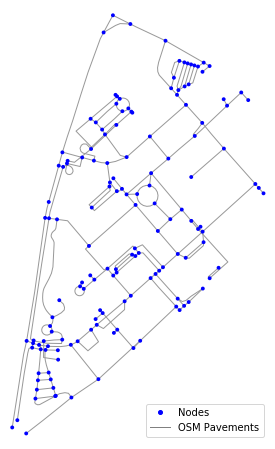

In [6]:
# Plot the OSM graph now for preview
graph_osm_copy = graph_osmnx.copy()
graph_osm_copy.remove_nodes_from(list(nx.isolates(graph_osm_copy)))
nc = ['b' for node in graph_osmnx.nodes]
fig, ax = ox.plot_graph(graph_osmnx.to_undirected(), node_color=nc, node_zorder=2,
                        fig_height = 8, fig_width = 8, show=False, close=False)
legends = [mpl.lines.Line2D([],[], color='b', marker='.', linestyle='None', markersize=8, label='Nodes'),
           mpl.lines.Line2D([0],[0], color='grey', lw=1, label='OSM Pavements')]
ax.legend(handles=legends, loc='lower right')

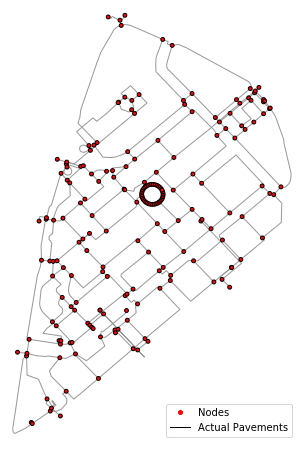

In [7]:
# Plot the reference graph now for preview
graph_ref = read_shp_with_node([node_ref, edge_ref], simplify=False)
graph_ref_copy = graph_ref.copy()
graph_ref_copy.graph['name'] = 'Pedestrian graph at East Tsim Sha Tsui'
graph_ref_copy.graph['crs'] = ref_proj
graph_ref_copy = ox.simplify_graph(graph_ref_copy, True)
graph_ref_copy.remove_nodes_from(list(nx.isolates(graph_ref_copy)))
# Dummy name
nc = ['r' for node in graph_ref_copy.nodes]
fig, ax = ox.plot_graph(graph_ref_copy.to_undirected(), node_color=nc, node_edgecolor='k', node_zorder=2,
                        fig_height = 8, fig_width = 8, equal_aspect=True, show=False, close=False)
legends = [mpl.lines.Line2D([],[], color='r', marker='.', linestyle='None', markersize=8, label='Nodes'),
           mpl.lines.Line2D([0],[0], color='k', lw=1, label='Actual Pavements')]
ax.legend(handles=legends, loc='lower right')

In [8]:
# Now calculate selected metrics other than centrality

graph_osm_dir = graph_osm_copy.to_directed()
graph_ref_dir = graph_ref_copy.to_directed()

graph_osm_analysis = graph_osm_copy.to_undirected()
graph_ref_analysis = graph_ref_copy.to_undirected()

graph_osm_simple = nx.Graph(graph_osm_copy)
graph_ref_simple = nx.Graph(graph_ref_copy)

# Average Degree Connectivity
print("Average Degree Connectivity for OSM: "+str(nx.average_degree_connectivity(graph_osm_simple)))
print("Average Degree Connectivity for REF: "+str(nx.average_degree_connectivity(graph_ref_simple)))

# Average Path Length
print("Average Path Length for OSM: "+str(max([nx.average_shortest_path_length(C) for C in nx.connected_component_subgraphs(graph_osm_simple)])))
print("Average Path Length for REF: "+str(max([nx.average_shortest_path_length(C) for C in nx.connected_component_subgraphs(graph_ref_simple)])))

# Clustering Coefficient
print("Clustering Coefficient for OSM: " + str(nx.transitivity(graph_osm_simple)))
print("Clustering Coefficient for REF: " + str(nx.transitivity(graph_ref_simple)))

# Efficiency
print("Efficiency for OSM: " + str(nx.global_efficiency(graph_osm_analysis)))
print("Efficiency for REF: " + str(nx.global_efficiency(graph_ref_analysis)))

# Hierarchy
print("Flow hierarchy for OSM: " + str(nx.flow_hierarchy(graph_osm_dir)))
print("Flow hierarchy for REF: " + str(nx.flow_hierarchy(graph_ref_dir)))

Average Degree Connectivity for OSM: {2: 2.466666666666667, 4: 3.0454545454545454, 3: 2.9138576779026217, 1: 2.761904761904762}
Average Degree Connectivity for REF: {1: 2.4, 3: 2.7209302325581395, 4: 2.607142857142857, 2: 2.1382978723404253}
Average Path Length for OSM: 8.560971302428255
Average Path Length for REF: 9.5
Clustering Coefficient for OSM: 0.03305785123966942
Clustering Coefficient for REF: 0.008645533141210375
Efficiency for OSM: 0.15924237698625723
Efficiency for REF: 0.0791803379013556
Flow hierarchy for OSM: 0.0
Flow hierarchy for REF: 0.7377777777777778


In [9]:
# Now calculate centrality

# Degree Centrality
deg_centrality_osm = nx.degree_centrality(graph_osm_analysis)
deg_centrality_ref = nx.degree_centrality(graph_ref_analysis)

# Betweenness Centrality
btwn_centrality_osm = nx.betweenness_centrality(graph_osm_analysis)
btwn_centrality_ref = nx.betweenness_centrality(graph_ref_analysis)

# Closeness Centrality
close_centrality_osm = nx.closeness_centrality(graph_osm_analysis)
close_centrality_ref = nx.closeness_centrality(graph_ref_analysis)


# ECDF for centrality. Use for comparison
deg_centrality_osm_ecdf = ECDF([v for k,v in deg_centrality_osm.items()])
btwn_centrality_osm_ecdf = ECDF([v for k,v in btwn_centrality_osm.items()])
close_centrality_osm_ecdf = ECDF([v for k,v in close_centrality_osm.items()])


deg_centrality_ref_ecdf = ECDF([v for k,v in deg_centrality_ref.items()])
btwn_centrality_ref_ecdf = ECDF([v for k,v in btwn_centrality_ref.items()])
close_centrality_ref_ecdf = ECDF([v for k,v in close_centrality_ref.items()])


# Summarize statistics
centrality_osm = dict()
centrality_percentile_osm = dict()
for k, v in deg_centrality_osm.items():
    centrality_osm[k] =  v
    centrality_percentile_osm[k] = deg_centrality_osm_ecdf(v)
for k, v in btwn_centrality_osm.items():
    if (centrality_osm[k] is not None):
        centrality_osm[k] = centrality_osm.get(k) + v
        centrality_percentile_osm[k] = centrality_percentile_osm.get(k) + btwn_centrality_osm_ecdf(v)
    else:
        centrality_osm[k] =  v
        centrality_percentile_osm[k] = btwn_centrality_osm_ecdf(k)
for k, v in close_centrality_osm.items():
    if (centrality_osm[k] is not None):
        centrality_osm[k] = centrality_osm.get(k) + v
        centrality_percentile_osm[k] = centrality_percentile_osm.get(k) + close_centrality_osm_ecdf(v)
    else:
        centrality_osm[k] =  v
        centrality_percentile_osm[k] = close_centrality_osm_ecdf(v)
    
centrality_ref = dict()
centrality_percentile_ref = dict()
for k, v in deg_centrality_ref.items():
    centrality_ref[k] = v
    centrality_percentile_ref[k] = deg_centrality_ref_ecdf(v)
for k, v in btwn_centrality_ref.items():
    if (centrality_ref[k] is not None):
        centrality_ref[k] = centrality_ref.get(k) + v
        centrality_percentile_ref[k] = centrality_percentile_ref.get(k) + btwn_centrality_ref_ecdf(v)
    else:
        centrality_ref[k] =  v
        centrality_percentile_ref[k] = btwn_centrality_osm_ecdf(v)
for k, v in close_centrality_ref.items():
    if (centrality_ref[k] is not None):
        centrality_ref[k] = centrality_ref.get(k) + v
        centrality_percentile_ref[k] = centrality_percentile_ref.get(k) + close_centrality_ref_ecdf(v)
    else:
        centrality_ref[k] =  v
        centrality_percentile_ref[k] = close_centrality_osm_ecdf(v)

        
        
# Prepare to show the result
l_centrality_osm = [v/3 for k,v in centrality_osm.items()]
l_centrality_osm_ecdf = ECDF(l_centrality_osm)
l_centrality_osm_sum_ecdf = [l_centrality_osm_ecdf(v) for v in l_centrality_osm]
l_centrality_percentile_osm = [v/3 for k,v in centrality_percentile_osm.items()]

l_centrality_osm.sort(reverse=True)
l_centrality_osm_high = l_centrality_osm[:len(l_centrality_osm)//10]

l_centrality_percentile_osm = np.array(l_centrality_percentile_osm)
l_centrality_percentile_osm[::-1].sort()

l_centrality_ref = [v/3 for k,v in centrality_ref.items()]
l_centrality_ref_ecdf = ECDF(l_centrality_ref)
l_centrality_percentile_ref = [v/3 for k,v in centrality_percentile_ref.items()]

l_centrality_ref.sort(reverse=True)
l_centrality_ref_high = l_centrality_ref[:len(l_centrality_ref)//10]

l_centrality_percentile_ref = np.array(l_centrality_percentile_ref)
l_centrality_percentile_ref[::-1].sort()


Text(0, 0.5, 'Sum of the centralities')

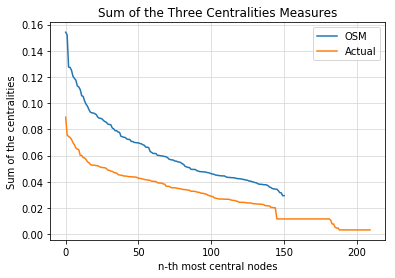

In [10]:
# Figure: sum of three centralities
plt.plot(l_centrality_osm, label='OSM')
plt.plot(l_centrality_ref, label='Actual')

plt.legend(loc='upper right')
plt.grid(True, color=(0.85,0.85,0.85))
plt.title("Sum of the Three Centralities Measures")
plt.xlabel("n-th most central nodes")
plt.ylabel("Sum of the centralities")

D:\FYP\conda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
D:\FYP\conda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Probability')

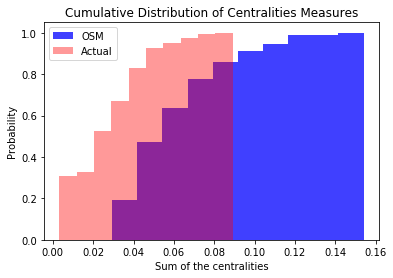

In [11]:
#CDF of summing three centralities

plt.hist(l_centrality_osm, normed=True, cumulative=True, label='OSM',
         histtype='stepfilled', color=(0,0,1,0.75))
plt.hist(l_centrality_ref, normed=True, cumulative=True, label='Actual',
         histtype='stepfilled', color=(1,0,0,0.4))
#legends = [mpl.lines.Line2D([],[], color='b' label='OSM'), mpl.lines.Line2D([],[], color='r' label='Actual')]
plt.legend(loc='upper left')
plt.title("Cumulative Distribution of Centralities Measures")
plt.xlabel("Sum of the centralities")
plt.ylabel("Probability")

Text(0, 0.5, 'Percentile of the sum of three centralities')

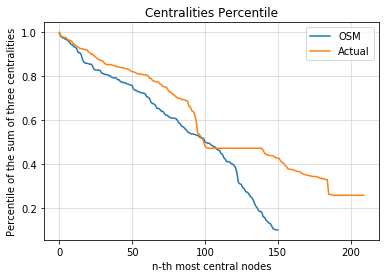

In [12]:
# Use Percentile instead of sum of three centralities values

plt.plot(l_centrality_percentile_osm, label="OSM")
plt.plot(l_centrality_percentile_ref, label="Actual")

plt.legend(loc='upper right')
plt.grid(True, color=(0.85,0.85,0.85))
plt.title("Centralities Percentile")
plt.xlabel("n-th most central nodes")
plt.ylabel("Percentile of the sum of three centralities")

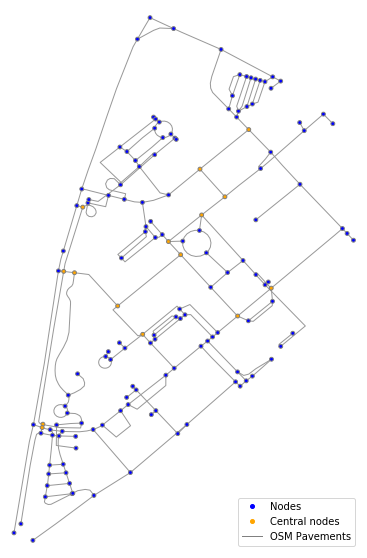

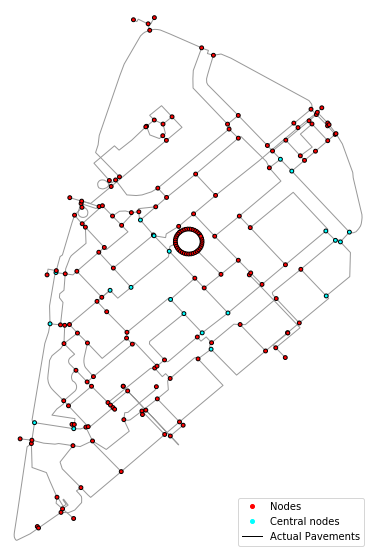

In [13]:
# Plot the Graph to show central nodes

central_nc_osm = []
for node in graph_osm_analysis.nodes():
    if (centrality_osm.get(node)/3) in l_centrality_osm_high:
        central_nc_osm.append('orange')
    else:
        central_nc_osm.append('b')
fig, ax = ox.plot_graph(graph_osm_analysis, node_color=central_nc_osm, node_edgecolor='grey', node_zorder=2,
                        fig_height = 10, fig_width = 10, equal_aspect=True, show=False, close=False)
legends = [mpl.lines.Line2D([],[], color='b', marker='.', linestyle='None', markersize=8, label='Nodes'),
           mpl.lines.Line2D([],[], color='orange', marker='.', linestyle='None', markersize=8, label='Central nodes'),
           mpl.lines.Line2D([0],[0], color='grey', lw=1, label='OSM Pavements')]
ax.legend(handles=legends, loc='lower right')


central_nc_ref = []
for node in graph_ref_analysis.nodes():
    if (centrality_ref.get(node)/3) in l_centrality_ref_high:
        central_nc_ref.append('cyan')
    else:
        central_nc_ref.append('r')
fig, ax = ox.plot_graph(graph_ref_analysis, node_color=central_nc_ref, node_edgecolor='k', node_zorder=2,
                        fig_height = 10, fig_width = 10, equal_aspect=True, show=False, close=False)
legends = [mpl.lines.Line2D([],[], color='r', marker='.', linestyle='None', markersize=8, label='Nodes'),
           mpl.lines.Line2D([],[], color='cyan', marker='.', linestyle='None', markersize=8, label='Central nodes'),
           mpl.lines.Line2D([0],[0], color='k', lw=1, label='Actual Pavements')]
ax.legend(handles=legends, loc='lower right')

In [14]:
#nx.graph_edit_distance(graph_osm_analysis, graph_ref_analysis)